# <font color='red'> Spoken Digit Recognition</font>


Input - speech signal, output - digit number

1. Reading the dataset. and Preprocess the data set. 
2. Training the LSTM with RAW data
3. Converting to spectrogram and Training the LSTM network
4. Creating the augmented data and doing step 2 and 3 again.  


In [1]:
import numpy as np
import pandas as pd
import librosa
import os
import warnings
warnings.filterwarnings('ignore')

In [82]:
#read the all file names in the recordings folder
#save those files names as list in "all_files"
import zipfile
with zipfile.ZipFile("recordings.zip","r") as zip_ref:
    zip_ref.extractall("recordings")

In [22]:
# folder path
files = os.listdir("recordings/recordings")

In [23]:
# appending file names with folder path
all_files = []
for i in files:
    all_files.append("recordings/recordings/" + i)

## Creating dataframe

Create a dataframe(name=df_audio) with two columns(path, label).   
You can get the label from the first letter of name.  
Eg: 0_jackson_0 --> 0  
0_jackson_43 --> 0

In [25]:
df_audio = pd.DataFrame(columns=['path','label'])

In [26]:
# splitting label value from file name
label = []
for i in files:
    label.append(int(i[0]))

In [27]:
df_audio['path'] = all_files
df_audio['label'] = label
df_audio

,path,label
0,recordings/recordings/0_jackson_0.wav,0
1,recordings/recordings/0_jackson_1.wav,0
2,recordings/recordings/0_jackson_10.wav,0
3,recordings/recordings/0_jackson_11.wav,0
4,recordings/recordings/0_jackson_12.wav,0
...,...,...
1995,recordings/recordings/9_yweweler_5.wav,9
1996,recordings/recordings/9_yweweler_6.wav,9
1997,recordings/recordings/9_yweweler_7.wav,9
1998,recordings/recordings/9_yweweler_8.wav,9


In [8]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


## Exploring the sound dataset

In [28]:
# checking for duplicate file

print('unique files:',len(df_audio['path'].unique()))

unique files: 2000


In [29]:
import IPython

# playing some random file
IPython.display.Audio(df_audio['path'][0])

In [30]:
IPython.display.Audio(df_audio['path'][1000])

In [31]:
IPython.display.Audio(df_audio['path'][1700])

In [33]:
#### visualizing audio file

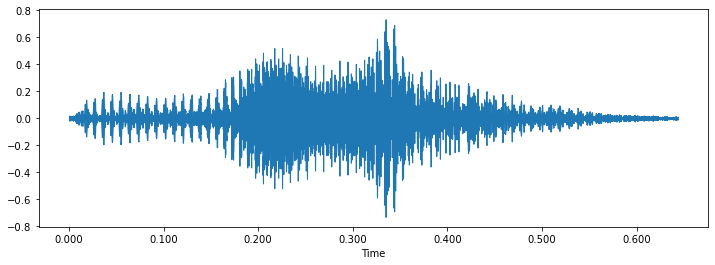

In [32]:
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt

#https://medium.com/@aboltaev404/audio-visualization-88f5cff5e0b4 - reference link
plt.figure(figsize=(12,4))
samples,sample_rate = librosa.load(df_audio['path'][0])
librosa.display.waveshow(samples,sr=sample_rate)
ipd.Audio(df_audio['path'][0])

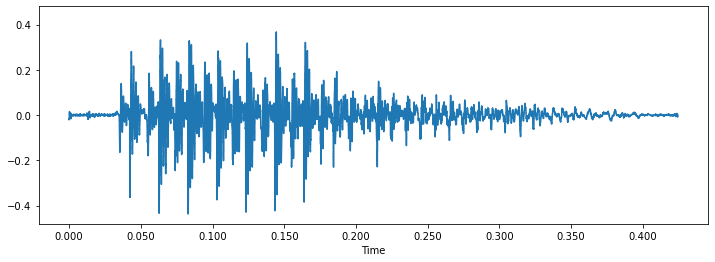

In [34]:
plt.figure(figsize=(12,4))
samples,sample_rate = librosa.load(df_audio['path'][1000])
librosa.display.waveshow(samples,sr=sample_rate)
ipd.Audio(df_audio['path'][1000])

In [35]:
from sklearn.utils import shuffle
df_audio = shuffle(df_audio, random_state=33)#don't change the random state

<pre><font size=4>Train and Validation split</font></pre>

In [36]:
#split the data into train and validation and save in X_train, X_test, y_train, y_test
#use stratify sampling
#use random state of 45
#use test size of 30%
from sklearn.model_selection import train_test_split

X = df_audio['path']
Y = df_audio['label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify = Y,random_state = 45)

<pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [38]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return [samples, duration]
    else:
        return samples

In [ ]:
#use load_wav function that was written above to get every wave. 
#save it in X_train_processed and X_test_processed
# X_train_processed/X_test_processed should be dataframes with two columns(raw_data, duration) with same index of X_train/y_train


In [39]:
# creating dataframe for train and test with raw data
X_train_processed = pd.DataFrame(columns=['raw_data','duration'])
X_test_processed = pd.DataFrame(columns=['raw_data','duration'])

In [40]:
X_train_data = []
for i in X_train:
    X_train_data.append(load_wav(i))
    
X_test_data = []
for i in X_test:
    X_test_data.append(load_wav(i))

In [41]:
# converting list to array
X_train_data = np.asarray(X_train_data)
X_test_data = np.asarray(X_test_data)

In [42]:
X_train_processed['raw_data'] = X_train_data[:,0]
X_train_processed['duration'] = X_train_data[:,1]
X_train_processed

,raw_data,duration
0,"[0.00011394074, 0.00012640332, 0.00012745972, ...",0.27678
1,"[0.015462314, 0.018172165, 0.01750962, 0.01515...",0.331519
2,"[0.0004158457, 0.00041390766, 7.270637e-05, -0...",0.292789
3,"[-0.00891809, -0.009839113, -0.009143287, -0.0...",0.344127
4,"[-0.009553918, -0.011437664, -0.011789859, -0....",0.659637
...,...,...
1395,"[0.00012828551, 0.00021638957, 0.00024526272, ...",0.262268
1396,"[-0.00013375799, -5.0936123e-05, 6.874241e-05,...",0.628254
1397,"[-0.012731153, -0.01254723, -0.01152263, -0.01...",0.464535
1398,"[-0.00034597443, -0.00027550157, -0.0001137347...",0.291293


In [43]:
X_test_processed['raw_data'] = X_test_data[:,0]
X_test_processed['duration'] = X_test_data[:,1]
X_test_processed

,raw_data,duration
0,"[0.00026219303, -3.563086e-05, -0.00013999043,...",0.314875
1,"[0.00032088827, -0.00014278508, -0.000590515, ...",0.51542
2,"[-0.00024847803, -0.00021077276, -0.0001466390...",0.269161
3,"[-0.004263563, -0.0033240004, -0.001765571, -0...",0.759274
4,"[0.00068556523, 0.0009813531, 0.0011631872, 0....",0.495646
...,...,...
595,"[-0.00029003862, -0.00030693837, -0.0002507312...",0.416417
596,"[-0.0012507439, 0.00054022064, 0.0017434349, 0...",0.508254
597,"[0.015125332, 0.00305088, -0.016935596, -0.032...",0.620771
598,"[-0.0001804145, -0.00012280767, 7.741404e-05, ...",0.337642


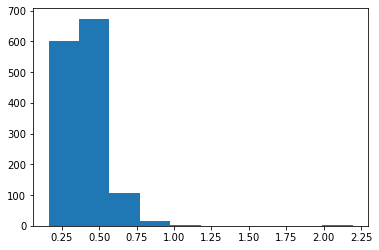

In [44]:
#plot the histogram of the duration for trian

plt.hist(X_train_processed['duration'])
plt.show()

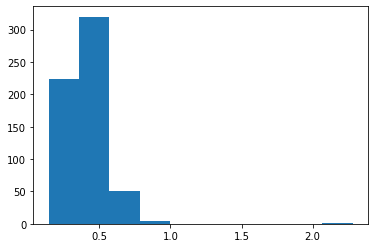

In [45]:
#plot the histogram of the duration for test

plt.hist(X_test_processed['duration'])
plt.show()

#### summary on duration:
1. Train files: most of the files lie within duration range 0.16 to 0.79, some files also lie in range above 2 seconds
2. Test files: most of the files lie within duration range 0.15 to 0.75, some files also lie in range above 2 seconds
    
so we will be considering files duration upto range 0.8 seconds

In [49]:
#print 0 to 100 percentile values with step size of 10 for train data duration. 

per = [0,10,20,30,40,50,60,70,75,80,90,100]
for i in per:
    print(i,'th percentile is',np.percentile(X_train_processed['duration'],i))

0 th percentile is 0.16104308390022676
10 th percentile is 0.25848072562358276
20 th percentile is 0.2974331065759637
30 th percentile is 0.3297777777777778
40 th percentile is 0.3569160997732426
50 th percentile is 0.38945578231292516
60 th percentile is 0.41328798185941046
70 th percentile is 0.4444671201814059
75 th percentile is 0.4614625850340136
80 th percentile is 0.48268480725623586
90 th percentile is 0.5531655328798186
100 th percentile is 2.195918367346939


In [47]:
##print 90 to 100 percentile values with step size of 1. 

per = [90,91,92,93,94,95,96,97,98,99,100]
for i in per:
    print(i,'th percentile is',np.percentile(X_train_processed['duration'],i))

90 th percentile is 0.5531655328798186
91 th percentile is 0.5669832199546486
92 th percentile is 0.5790349206349207
93 th percentile is 0.5995106575963719
94 th percentile is 0.611208163265306
95 th percentile is 0.6316009070294784
96 th percentile is 0.6431455782312925
97 th percentile is 0.6635741496598639
98 th percentile is 0.6957514739229022
99 th percentile is 0.79601179138322
100 th percentile is 2.195918367346939


<b>Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset.</b>

<b>While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640
</b>
<b>Pad with Zero if length of sequence is less than 17640 else Truncate the number. </b>

<b> Also create a masking vector for train and test. </b>

<b> masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.</b>


In [3]:
max_length  = 17640

In [50]:
X_train_processed['raw_data']

0       [0.00011394074, 0.00012640332, 0.00012745972, ...
1       [0.015462314, 0.018172165, 0.01750962, 0.01515...
2       [0.0004158457, 0.00041390766, 7.270637e-05, -0...
3       [-0.00891809, -0.009839113, -0.009143287, -0.0...
4       [-0.009553918, -0.011437664, -0.011789859, -0....
                              ...                        
1395    [0.00012828551, 0.00021638957, 0.00024526272, ...
1396    [-0.00013375799, -5.0936123e-05, 6.874241e-05,...
1397    [-0.012731153, -0.01254723, -0.01152263, -0.01...
1398    [-0.00034597443, -0.00027550157, -0.0001137347...
1399    [-0.0184889, -0.004147246, 0.010863232, 0.0157...
Name: raw_data, Length: 1400, dtype: object

In [ ]:
## as discussed above, Pad with Zero if length of sequence is less than 17640 else Truncate the number. 
## save in the X_train_pad_seq, X_test_pad_seq
## also Create masking vector X_train_mask, X_test_mask

## all the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays mask vector dtype must be bool.

### padding

In [51]:
len(X_train_processed['raw_data'][0])

6103

In [52]:
X_train_pad_seq = []
for i in range(len(X_train_processed)):
    if len(X_train_processed['raw_data'][i])>max_length:
        X_train_pad_seq.append(X_train_processed['raw_data'][i][:max_length])
    else:
        X_train_pad_seq.append(np.concatenate((X_train_processed['raw_data'][i] , np.asarray([0]*(max_length-len(X_train_processed['raw_data'][i]))))))

In [53]:
len(X_train_pad_seq[0])

17640

In [24]:
X_test_pad_seq = []
for i in range(len(X_test_processed)):
    if len(X_test_processed['raw_data'][i])>max_length:
        X_test_pad_seq.append(X_test_processed['raw_data'][i][:max_length])
    else:
        X_test_pad_seq.append(np.concatenate((X_test_processed['raw_data'][i] , np.asarray([0]*(max_length-len(X_test_processed['raw_data'][i]))))))

### masking

In [67]:
X_train_mask = []
for i in X_train_pad_seq:
    masking = []
    for j in i:
        if j==0:
            masking.append(0)
        else:
            masking.append(1)
    X_train_mask.append(masking)

In [26]:
X_test_mask = []
for i in X_test_pad_seq:
    masking = []
    for j in i:
        if j==0:
            masking.append(0)
        else:
            masking.append(1)
    X_test_mask.append(masking)

In [27]:
X_train_pad_seq = np.asarray(X_train_pad_seq)
X_test_pad_seq = np.asarray(X_test_pad_seq)
X_train_mask = np.asarray(X_train_mask)
X_test_mask = np.asarray(X_test_mask)

In [28]:
y_train.dtype

dtype('int64')

In [29]:
X_train_mask = X_train_mask.astype('bool')
X_test_mask = X_test_mask.astype('bool')

### 1. Giving Raw data directly. 

Train data: X_train_pad_seq, X_train_mask and y_train  
Test data: X_test_pad_seq, X_test_mask and y_test   

create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_pad_seq" as input, "X_train_mask" as mask input. 
2. Get the final output of the LSTM and give it to Dense layer of any size and then give it to Dense layer of size 10(because we have 10 outputs) and then compile with the sparse categorical cross entropy( because we are not converting it to one hot vectors).
3. While defining model pass both the input layer and mask input layer as input to lstm layer as follows
<img src='https://i.imgur.com/FvcgvbY.jpg'>

In [4]:
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, BatchNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score ,auc ,roc_curve, roc_auc_score

In [45]:
training_data = ([X_train_pad_seq, X_train_mask],y_train)
validation_data=([X_test_pad_seq, X_test_mask],y_test)

class metrics_calculate(tf.keras.callbacks.Callback):
    def __init__(self,training_data,validation_data):
        super(metrics_calculate,self).__init__()
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_test = validation_data[0]
        self.y_test = validation_data[1]
        
    def on_train_begin(self, logs={}):
        self.val_f1s=[]
        
    def on_epoch_end(self, epochs, logs={}):
        val_predict = np.asarray(self.model.predict(self.x_test))
        val_label = np.argmax(val_predict,axis=1)
        val_targ = self.y_test
        _val_f1 = f1_score(val_targ, val_label,average='micro')
        ##self.val_f1s.append(_val_f1)
        print(' micro F1 score :',_val_f1)
        
        #https://towardsdatascience.com/a-quickstart-guide-to-tensorboard-fb1ade69bbcf
        summary_writer = tf.summary.create_file_writer(log_dir + '/micro_f1_score')
        
        #writing to tensoboard
        with summary_writer.as_default():
            tf.summary.scalar('validation micro_f1_score', _val_f1, step=epochs)
        
metrics=metrics_calculate(training_data,validation_data)

In [6]:
%load_ext tensorboard

In [47]:
import shutil
shutil.rmtree('logs/model1/')

In [7]:
import datetime

In [49]:
log_dir="logs/model1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [50]:
amp_input = Input(shape=(max_length,1),name='input_text')
mask_input = Input(shape=(max_length),dtype='bool')

lstm = LSTM(128, name='lstm')(amp_input,mask=mask_input)

dense1 = Dense(64, activation='relu',kernel_initializer=tf.keras.initializers.he_normal(),name='dense1')(lstm)

out = Dense(10,activation='softmax',kernel_initializer=tf.keras.initializers.he_normal(),name='output')(dense1)

model1 = Model(inputs=[amp_input,mask_input],outputs=out)

model1.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [51]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         [(None, 17640, 1)]   0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 17640)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          66560       input_text[0][0]                 
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
dense1 (Dense)                  (None, 64)           8256        lstm[0][0]                   

In [52]:
#train your model
model1.fit([X_train_pad_seq,X_train_mask], y_train, validation_data = ([X_test_pad_seq, X_test_mask], y_test), epochs=4, callbacks=[metrics,tensorboard_callback])

Epoch 1/4
44/44 [==============================] - 91s 2s/step - loss: 2.3045 - accuracy: 0.0814 - val_loss: 2.3026 - val_accuracy: 0.1000
 micro F1 score : 0.10000000000000002
Epoch 2/4
44/44 [==============================] - 62s 1s/step - loss: 2.3037 - accuracy: 0.0893 - val_loss: 2.3026 - val_accuracy: 0.1000
 micro F1 score : 0.10000000000000002
Epoch 3/4
44/44 [==============================] - 49s 1s/step - loss: 2.3033 - accuracy: 0.0979 - val_loss: 2.3026 - val_accuracy: 0.1000
 micro F1 score : 0.10000000000000002
Epoch 4/4
44/44 [==============================] - 54s 1s/step - loss: 2.3031 - accuracy: 0.0964 - val_loss: 2.3026 - val_accuracy: 0.1000
 micro F1 score : 0.10000000000000002


In [ ]:
%tensorboard --logdir="C:\Users\paart\spoken digit recognition\logs\model1\20220719-215232"

### 2. Converting into spectrogram and giving spectrogram data as input  

use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e converting Time domain to frequency domain. 


In [8]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [36]:
X_train_pad_seq.shape

(1400, 17640)

In [37]:
##use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)

X_train_spectrogram = []
for i in X_train_pad_seq:
    X_train_spectrogram.append(convert_to_spectrogram(i))

In [38]:
X_test_spectrogram = []
for i in X_test_pad_seq:
    X_test_spectrogram.append(convert_to_spectrogram(i))

In [39]:
X_train_spectrogram = np.asarray(X_train_spectrogram)
X_test_spectrogram = np.asarray(X_test_spectrogram)


Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_spectrogram" as input and has to return output at every time step. 
2. Average the output of every time step and give this to the Dense layer of any size. 
(ex: Output from LSTM will be  (None, time_steps, features) average the output of every time step i.e, should get (None,time_steps) 
and then pass to dense layer )
3. give the above output to Dense layer of size 10( output layer) and train the network with sparse categorical cross entropy. 


In [48]:
training_data = (X_train_spectrogram,y_train)
validation_data=(X_test_spectrogram,y_test)
        
metrics=metrics_calculate(training_data,validation_data)

In [49]:
import shutil
shutil.rmtree('logs/model2/')

In [50]:
log_dir="logs/model2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [51]:
X_train_spectrogram.shape

(1400, 64, 35)

In [52]:
spec_input = Input(shape=(64, 35,),name='input_text')

lstm = LSTM(100, return_sequences=True, name='lstm')(spec_input)

pool = GlobalAveragePooling1D(name='pool')(lstm)

dense1 = Dense(128, activation='relu',kernel_initializer=tf.keras.initializers.he_normal(),name='dense1')(pool)

out = Dense(10,activation='softmax',kernel_initializer=tf.keras.initializers.he_normal(),name='output')(dense1)

model2 = Model(inputs=spec_input,outputs=out)

model2.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [53]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text (InputLayer)      [(None, 64, 35)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64, 100)           54400     
_________________________________________________________________
pool (GlobalAveragePooling1D (None, 100)               0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               12928     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 68,618
Trainable params: 68,618
Non-trainable params: 0
_________________________________________________________________


In [54]:
#compile and fit your model.
model2.fit(X_train_spectrogram, y_train, validation_data = (X_test_spectrogram, y_test), epochs=50, callbacks=[metrics,tensorboard_callback])

Epoch 1/50
44/44 [==============================] - 2s 22ms/step - loss: 2.1783 - accuracy: 0.2107 - val_loss: 2.0759 - val_accuracy: 0.2867
 micro F1 score : 0.2866666666666667
Epoch 2/50
44/44 [==============================] - 0s 8ms/step - loss: 1.9802 - accuracy: 0.3307 - val_loss: 1.8462 - val_accuracy: 0.3717
 micro F1 score : 0.37166666666666665
Epoch 3/50
44/44 [==============================] - 0s 9ms/step - loss: 1.8064 - accuracy: 0.3721 - val_loss: 1.7317 - val_accuracy: 0.4333
 micro F1 score : 0.43333333333333335
Epoch 4/50
44/44 [==============================] - 0s 8ms/step - loss: 1.6614 - accuracy: 0.4493 - val_loss: 1.5683 - val_accuracy: 0.5017
 micro F1 score : 0.5016666666666667
Epoch 5/50
44/44 [==============================] - 0s 8ms/step - loss: 1.5522 - accuracy: 0.4764 - val_loss: 1.4848 - val_accuracy: 0.5483
 micro F1 score : 0.5483333333333333
Epoch 6/50
44/44 [==============================] - 0s 7ms/step - loss: 1.5174 - accuracy: 0.5036 - val_loss: 1.

In [ ]:
%tensorboard --logdir="C:\Users\paart\spoken digit recognition\logs\model2\20220719-230703"

### 3. Data augmentation with raw features 

Till now we have done with 2000 samples only. It is very less data. We are giving the process of generating augmented data below.

There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.


In [54]:
## generating augmented data. 
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path,get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [55]:
temp_path = df_audio.iloc[0].path
aug_temp = generate_augmented_data(temp_path)

In [56]:
len(aug_temp)

9

## Follow the steps 

1. Split data 'df_audio' into train and test (80-20 split)

2. We have 2000 data points(1600 train points, 400 test points) 



In [57]:
X_train, X_test, y_train, y_test=train_test_split(df_audio['path'],df_audio['label'],random_state=45,test_size=0.2,stratify=df_audio['label'])

3. Do augmentation only on X_train,pass each point of X_train to generate_augmented_data function.After augmentation we will get 14400 train points. Make sure that you are augmenting the corresponding class labels (y_train) also.
4. Preprocess your X_test using load_wav function.
5. Convert the augmented_train_data and test_data to numpy arrays.
6. Perform padding and masking on augmented_train_data and test_data.
7. After padding define the model similar to model 1 and fit the data

In [59]:
from tqdm import tqdm

In [60]:
# data augmentation

augmented_train_data = []
for i in tqdm(X_train):
    augmented_train_data.extend(generate_augmented_data(i))

100%|██████████████████████████████████████████████████████████████████████████████| 1600/1600 [04:01<00:00,  6.61it/s]


In [39]:
from itertools import repeat

# using repeat func data will be repeated given n time
train_label = []
for i in y_train:
    train_label.extend(repeat(i,9))

In [40]:
test_data = []
for i in X_test:
    test_data.append(load_wav(i, get_duration = False))

### padding

In [41]:
augmented_train_pad_seq = []
for i in range(len(augmented_train_data)):
    if len(augmented_train_data[i])>max_length:
        augmented_train_pad_seq.append(augmented_train_data[i][:max_length])
    else:
        augmented_train_pad_seq.append(np.concatenate((augmented_train_data[i] , np.asarray([0]*(max_length-len(augmented_train_data[i]))))))


In [42]:
test_pad_seq = []
for i in range(len(test_data)):
    if len(test_data[i])>max_length:
        test_pad_seq.append(test_data[i][:max_length])
    else:
        test_pad_seq.append(np.concatenate((test_data[i] , np.asarray([0]*(max_length-len(test_data[i]))))))


### masking

In [43]:
augmented_train_mask = []
for i in augmented_train_pad_seq:
    masking = []
    for j in i:
        if j==0:
            masking.append(0)
        else:
            masking.append(1)
    augmented_train_mask.append(masking)        

In [44]:
test_mask = []
for i in test_pad_seq:
    masking = []
    for j in i:
        if j==0:
            masking.append(0)
        else:
            masking.append(1)
    test_mask.append(masking)        

In [45]:
augmented_train_pad_seq = np.asarray(augmented_train_pad_seq)
test_pad_seq = np.asarray(test_pad_seq)
augmented_train_mask = np.asarray(augmented_train_mask)
test_mask = np.asarray(test_mask)
augmented_train_mask = augmented_train_mask.astype('bool')
test_mask = test_mask.astype('bool')

In [46]:
train_label = np.asarray(train_label)

In [47]:
train_label = train_label.astype('int64')

## storing padded, masked vector using pkl 

In [69]:
import pickle

# train data
with open('augmented_train_pad_seq.pkl', 'wb') as f:
    pickle.dump(augmented_train_pad_seq, f)
    
with open('augmented_train_mask.pkl', 'wb') as f:
    pickle.dump(augmented_train_mask, f)

with open('train_label.pkl', 'wb') as f:
    pickle.dump(train_label, f)
    
# test data
with open('test_pad_seq.pkl', 'wb') as f:
    pickle.dump(test_pad_seq, f)
    
with open('test_mask.pkl', 'wb') as f:
    pickle.dump(test_mask, f)

with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

## reading padded, masked vector using pkl 

In [10]:
import pickle

# train data
with open('augmented_train_pad_seq.pkl', 'rb') as f:
    augmented_train_pad_seq = pickle.load(f)
    
with open('augmented_train_mask.pkl', 'rb') as f:
    augmented_train_mask = pickle.load(f)
    
with open('train_label.pkl', 'rb') as f:
    train_label = pickle.load(f)
    
# test data
with open('test_pad_seq.pkl', 'rb') as f:
    test_pad_seq = pickle.load(f)
    
with open('test_mask.pkl', 'rb') as f:
    test_mask = pickle.load(f)

with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [17]:
training_data = ([augmented_train_pad_seq, augmented_train_mask], train_label)
validation_data=([test_pad_seq, test_mask], y_test)
        
metrics=metrics_calculate(training_data,validation_data)

In [ ]:
import shutil
shutil.rmtree('logs/model3/')

In [13]:
log_dir="logs/model3/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [14]:
aug_amp_input = Input(shape=(max_length,1),name='input_text')
mask_input = Input(shape=(max_length),dtype='bool')

lstm = LSTM(128, name='lstm')(aug_amp_input,mask=mask_input)

dense1 = Dense(64, activation='relu',kernel_initializer=tf.keras.initializers.he_normal(),name='dense1')(lstm)

out = Dense(10,activation='softmax',kernel_initializer=tf.keras.initializers.he_normal(),name='output')(dense1)

model3 = Model(inputs=[aug_amp_input,mask_input],outputs=out)

model3.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [15]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         [(None, 17640, 1)]   0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 17640)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          66560       input_text[0][0]                 
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
dense1 (Dense)                  (None, 64)           8256        lstm[0][0]                   

In [18]:
#train your model
model3.fit([augmented_train_pad_seq, augmented_train_mask], train_label, validation_data = ([test_pad_seq, test_mask], y_test), epochs=3,batch_size = 8, callbacks=[metrics,tensorboard_callback])

Epoch 1/3
1800/1800 [==============================] - 1476s 817ms/step - loss: 2.3036 - accuracy: 0.0957 - val_loss: 2.3028 - val_accuracy: 0.1000
 micro F1 score : 0.10000000000000002
Epoch 2/3
1800/1800 [==============================] - 1522s 846ms/step - loss: 2.3030 - accuracy: 0.0961 - val_loss: 2.3026 - val_accuracy: 0.1000
 micro F1 score : 0.10000000000000002
Epoch 3/3
1800/1800 [==============================] - 1477s 821ms/step - loss: 2.3030 - accuracy: 0.0942 - val_loss: 2.3026 - val_accuracy: 0.1000
 micro F1 score : 0.10000000000000002


In [ ]:
%tensorboard --logdir="C:\Users\paart\spoken digit recognition\logs\model3\20220721-115302"

### 4. Data augmentation with spectogram data

1. use convert_to_spectrogram and convert the padded data from train and test data to spectogram data.
2. The shape of train data will be 14400 x 64 x 35 and shape of test_data will be 400 x 64 x35
3. Define the model similar to model 2 and fit the data

In [26]:
##use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)

X_train_spectrogram = []
for i in augmented_train_pad_seq:
    X_train_spectrogram.append(convert_to_spectrogram(i))

X_test_spectrogram = []
for i in test_pad_seq:
    X_test_spectrogram.append(convert_to_spectrogram(i))

In [27]:
X_train_spectrogram = np.asarray(X_train_spectrogram)
X_test_spectrogram = np.asarray(X_test_spectrogram)

In [28]:
training_data = (X_train_spectrogram,train_label)
validation_data=(X_test_spectrogram,y_test)
        
metrics=metrics_calculate(training_data,validation_data)

In [29]:
import shutil
shutil.rmtree('logs/model4/')

In [30]:
log_dir="logs/model4/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [31]:
spec_input = Input(shape=(64, 35,),name='input_text')

lstm = LSTM(100, return_sequences=True, name='lstm')(spec_input)

pool = GlobalAveragePooling1D(name='pool')(lstm)

dense1 = Dense(128, activation='relu',kernel_initializer=tf.keras.initializers.he_normal(),name='dense1')(pool)

out = Dense(10,activation='softmax',kernel_initializer=tf.keras.initializers.he_normal(),name='output')(dense1)

model4 = Model(inputs=spec_input,outputs=out)

model4.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [32]:
model4.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text (InputLayer)      [(None, 64, 35)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64, 100)           54400     
_________________________________________________________________
pool (GlobalAveragePooling1D (None, 100)               0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               12928     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 68,618
Trainable params: 68,618
Non-trainable params: 0
_________________________________________________________________


In [33]:
#train your model
model4.fit(X_train_spectrogram, train_label, validation_data = (X_test_spectrogram, y_test), epochs=15, callbacks=[metrics,tensorboard_callback])

Epoch 1/15
450/450 [==============================] - 13s 11ms/step - loss: 1.8115 - accuracy: 0.3482 - val_loss: 1.4708 - val_accuracy: 0.5200
 micro F1 score : 0.52
Epoch 2/15
450/450 [==============================] - 5s 11ms/step - loss: 1.3517 - accuracy: 0.5364 - val_loss: 1.1550 - val_accuracy: 0.6125
 micro F1 score : 0.6125
Epoch 3/15
450/450 [==============================] - 4s 10ms/step - loss: 1.1163 - accuracy: 0.6151 - val_loss: 0.9256 - val_accuracy: 0.6950
 micro F1 score : 0.695
Epoch 4/15
450/450 [==============================] - 4s 9ms/step - loss: 0.9866 - accuracy: 0.6593 - val_loss: 0.8484 - val_accuracy: 0.7025
 micro F1 score : 0.7025
Epoch 5/15
450/450 [==============================] - 4s 9ms/step - loss: 0.9005 - accuracy: 0.6865 - val_loss: 0.7947 - val_accuracy: 0.7075
 micro F1 score : 0.7075
Epoch 6/15
450/450 [==============================] - 4s 9ms/step - loss: 0.8566 - accuracy: 0.7012 - val_loss: 0.7320 - val_accuracy: 0.7400
 micro F1 score : 0.74

In [ ]:
%tensorboard --logdir="C:\Users\paart\spoken digit recognition\logs\model4\20220721-002858"

# summary:

## Model 1:

### Loss & Micro F1 score  

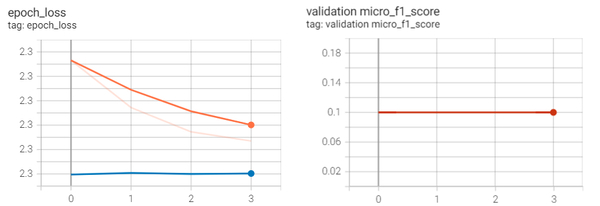

### Dense layer 1 & output layer

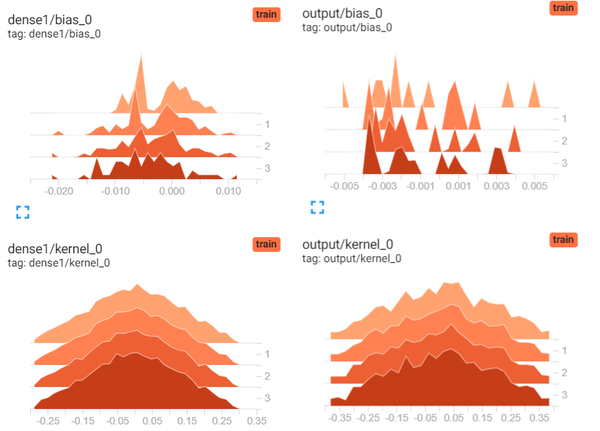

### lstm layer

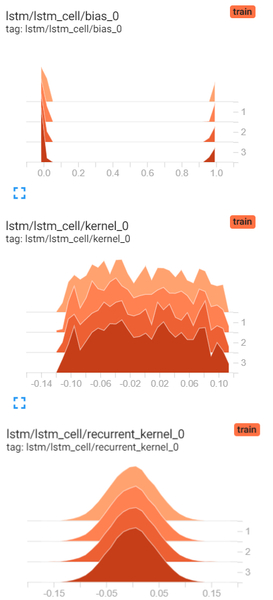

conclusion:
- there is no improvement in micro f1 score, showing poor performance
- most of the weights ranges from -0.25 to 0.25

---

### Model 2:

### Loss & Micro F1 score

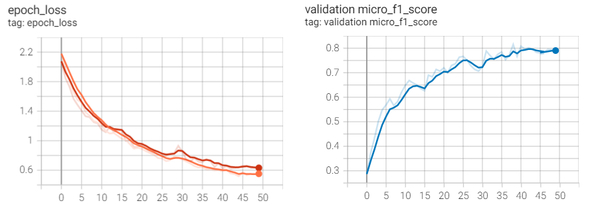

### Dense layer 1 & output layer

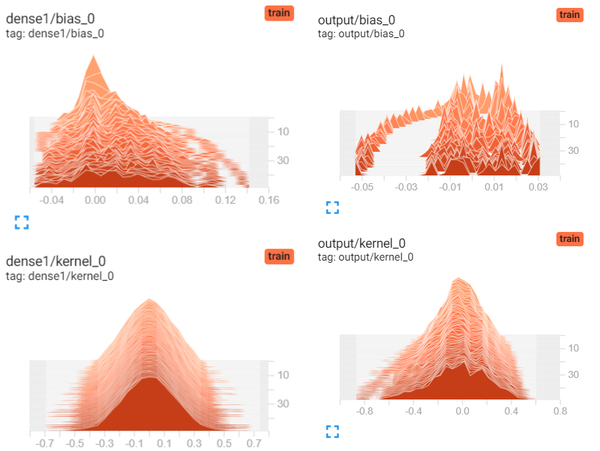

### lstm layer

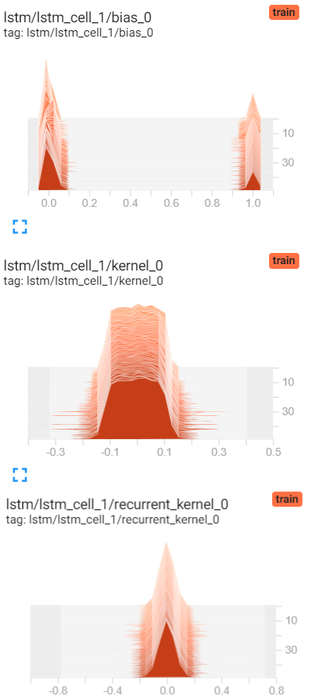

conclusion:
- there is good improvement in micro f1 score over epochs, showing improve in performance
- this is due to presence of spectogram data having frequency information over time
- most of the weights ranges from -0.5 to 0.5

---

## Model 3:

### Loss & Micro F1 score

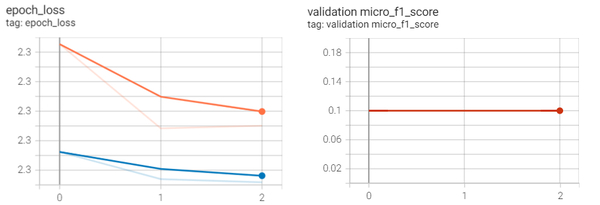

### Dense layer 1 & output layer

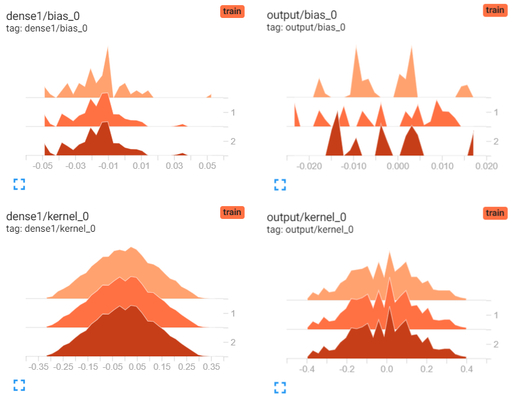

### lstm layer

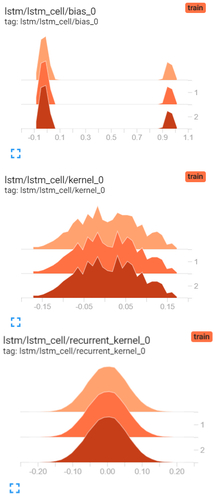

conclusion:
- there is no use in doing data augmentation using raw data
- there is no improvement in micro f1 score, showing poor performance
- most of the weights ranges from -0.4 to 0.4

---

### Model 4:

### Loss & Micro F1 score

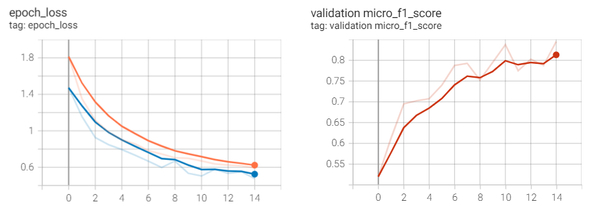

### Dense layer 1 & output layer

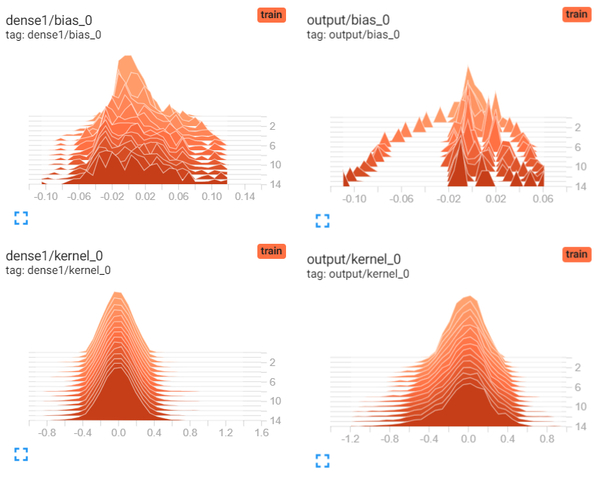

### lstm layer

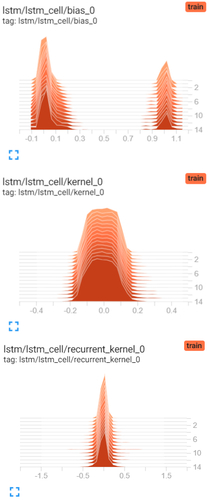

conclusion:
- achieve micro f1 score over 0.80 within 15 epochs, which more better than model 2
- it show more data help the model to learn good
- most of the weights ranges from -0.6 to 0.6